This is a very simple script which loads the chosen tdms file, reads the encoder data, computes the zone of stable rotation from the frequencies and plots the data. In the final plot, the first row is the whole data (downsampled at an arbitrary sampling rate when plotted), the second row is a zoom on the stability phase (still downsampled) and the last row is a further zoom on a small window (not donwsampled), whose width can be chosen. The second cell loads an excel file created with tdms_file_reader.ipynb and modified manually adding the information about Z thresholds, target frequency and if the tdms file is the google drive spreadsheet. Just run all the cells after selecting the tdms file you want to plot (third cell).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import os
import lib_bbmdev
import logging
from datetime import datetime
import sys
from pathlib import Path

%matplotlib inline

In [2]:
#initialize
os.chdir(r'C:\Users\ggora\DevelopingToolkit\bbm_run2_tdms')
path = "Data/2023_run2/"
excel_file = "tdms_dataframe_xlsx.xlsx"
df_excel = pd.read_excel(path+excel_file, header=1)
df_stable = df_excel.dropna()
df_stable.set_index("File", inplace = True)
df_stable

,0,Iu,Iv,Iw,A,B,Z,H,SV1,SV2,...,Count,Vu,Vv,Vw,Duration [s],Sampling Frequency [Hz],Low TH,High TH,Target freq [Hz],Is in Spreadsheet?
File,,,,,,,,,,,,,,,,,,,,,
tdms103_room-to-cryo.tdms,4,1,1,1,1,1,1,1,0,0,...,1,1,1,1,9348.000,1000,-0.5,0.5,1.0,Y
tdms104_room-to-cryo.tdms,5,1,1,1,1,1,1,1,0,0,...,1,1,1,1,15217.000,1000,-0.5,0.5,0.8,Y
tdms35_room-to-cryo.tdms,7,1,1,1,1,1,1,1,1,1,...,0,1,1,1,9959.000,1000,-8.0,-0.5,1.0,Y
tdms56_room-to-cryo.tdms,12,1,1,1,1,1,1,1,1,1,...,0,1,1,1,8452.000,1000,-8.0,-0.5,1.0,Y
tdms58_room-to-cryo.tdms,13,1,1,1,1,1,1,1,1,1,...,0,1,1,1,3648.000,1000,-8.0,-0.5,1.0,Y
tdms61_room-to-cryo.tdms,14,1,1,1,1,1,1,1,1,1,...,0,1,1,1,2105.000,1000,-8.0,-0.5,1.0,Y
tdms64_room-to-cryo.tdms,17,1,1,1,1,1,1,1,1,1,...,0,1,1,1,21744.009,1000,-8.0,-0.5,1.0,Y
tdms75_room-to-cryo.tdms,23,1,1,1,1,1,1,1,0,0,...,1,1,1,1,11302.000,1000,-0.5,0.5,1.0,Y
tdms88_room-to-cryo.tdms,29,1,1,1,1,1,1,1,0,0,...,1,1,1,1,11054.000,1000,-0.5,0.5,1.0,Y


In [3]:

filename = "tdms104_room-to-cryo.tdms"


df_signal = lib_bbmdev.tdms_load_selected_custom(path + 'tdms/'+filename , samplerate=1000, print_=True)

created_directory = lib_bbmdev.create_directory(filename)
os.chdir(created_directory)

df_signal

Directory '202403011803_tdms104_room-to-cryo.tdms' has been created.


,time,Iu,Iv,Iw,A,B,Z,H,Count,Vu,Vv,Vw
0,0.000,-0.000872,0.004944,0.004026,1.092061,0.421300,-0.547594,0.111686,-0.001538,-0.007424,-0.002294,-0.007306
1,0.001,-0.001192,0.004944,0.004026,1.092379,0.422248,-0.562233,0.111370,-0.000589,-0.002279,-0.002294,-0.002161
2,0.002,-0.000872,0.004628,0.004345,1.092698,0.422564,-0.588647,0.110105,-0.001222,-0.002279,-0.002294,-0.007306
3,0.003,-0.000553,0.005260,0.004664,1.091742,0.421932,-0.618880,0.115798,-0.001538,-0.007424,-0.002294,0.002983
4,0.004,-0.000553,0.004944,0.004345,1.092379,0.421616,-0.677755,0.111370,-0.001538,-0.007424,-0.007439,-0.007306
...,...,...,...,...,...,...,...,...,...,...,...,...
15216995,15216.995,-0.001192,0.004944,0.004345,1.085683,1.070755,-0.644976,0.112951,-10.380818,0.002865,-0.002294,-0.007306
15216996,15216.996,-0.001192,0.005260,0.004664,1.085045,1.069808,-0.727401,0.112951,-10.380818,-0.002279,-0.007439,0.002983
15216997,15216.997,-0.001192,0.004944,0.004664,1.085045,1.070124,-0.826056,0.112319,-10.380818,-0.002279,0.002850,-0.002161
15216998,15216.998,-0.000553,0.004944,0.004026,1.085683,1.070440,-0.909118,0.113268,-10.380818,0.002865,-0.002294,0.002983


In [4]:
# ログの設定
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# ログのフォーマットを設定
formatter = logging.Formatter('%(asctime)s - %(message)s')

# ログのファイル出力先を設定
log_file = 'analysis.log'
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 解析開始時刻
start_time = datetime.now()

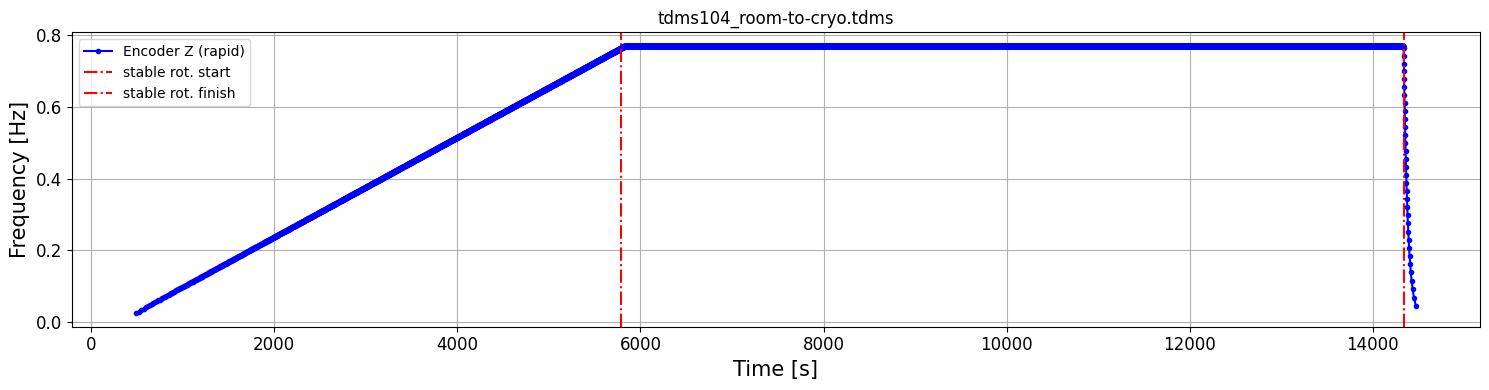

In [5]:
#%%time
#frequency
#encorder_threshold_high = 0.
#encorder_threshold_low = -4.
low_th, high_th, target_freq = df_stable.loc[filename, ['Low TH', 'High TH', 'Target freq [Hz]']]
threshold,time_stamps=lib_bbmdev.triggerd_window(df_signal['Z'].to_numpy(),df_signal['time'].to_numpy(),high_threshold=high_th,low_threshold=low_th,window_size=5)
period,freq=lib_bbmdev.time2freq(time_stamps)

try:
    if target_freq == 0.8:
        stable_index = np.where((freq>0.955*target_freq)&(freq<1.01*target_freq))[0]
    else:
        stable_index = np.where((freq>target_freq)&(freq<1.01*target_freq))[0]
    stable_str = time_stamps[1:][stable_index[0]]
    stable_fin = time_stamps[1:][stable_index[-1]]
except:
    stable_str = np.inf
    stable_fin = np.inf

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(111)
ax.plot(time_stamps[1:],freq,'b.-',label = 'Encoder Z (rapid)') # frequency
ax.axvline(x = stable_str,c = 'r',ls='-.',label = 'stable rot. start') # vertical line at the start
ax.axvline(x = stable_fin,c = 'r',ls='-.',label = 'stable rot. finish') # vertical line at the finish
ax.grid()
ax.set_xlabel('Time [s]',fontsize = 15)
ax.set_ylabel(r'Frequency [Hz]', fontsize = 15)
ax.tick_params(labelsize = 12)
ax.legend()
#ax.set_ylim(0,1.1)
#ax.set_ylim(0.2,0.27)
#ax.set_xlim(2100,2900)
ax.set_title(filename)
plt.tight_layout()
plt.savefig(
           "./" + "frequency.jpg",
           dpi=130,
       )
plt.show()


0.9332483690000001 1.0917416690000001
0.9156568680000001 1.0906560500000002
-1.029731839 1.090403027


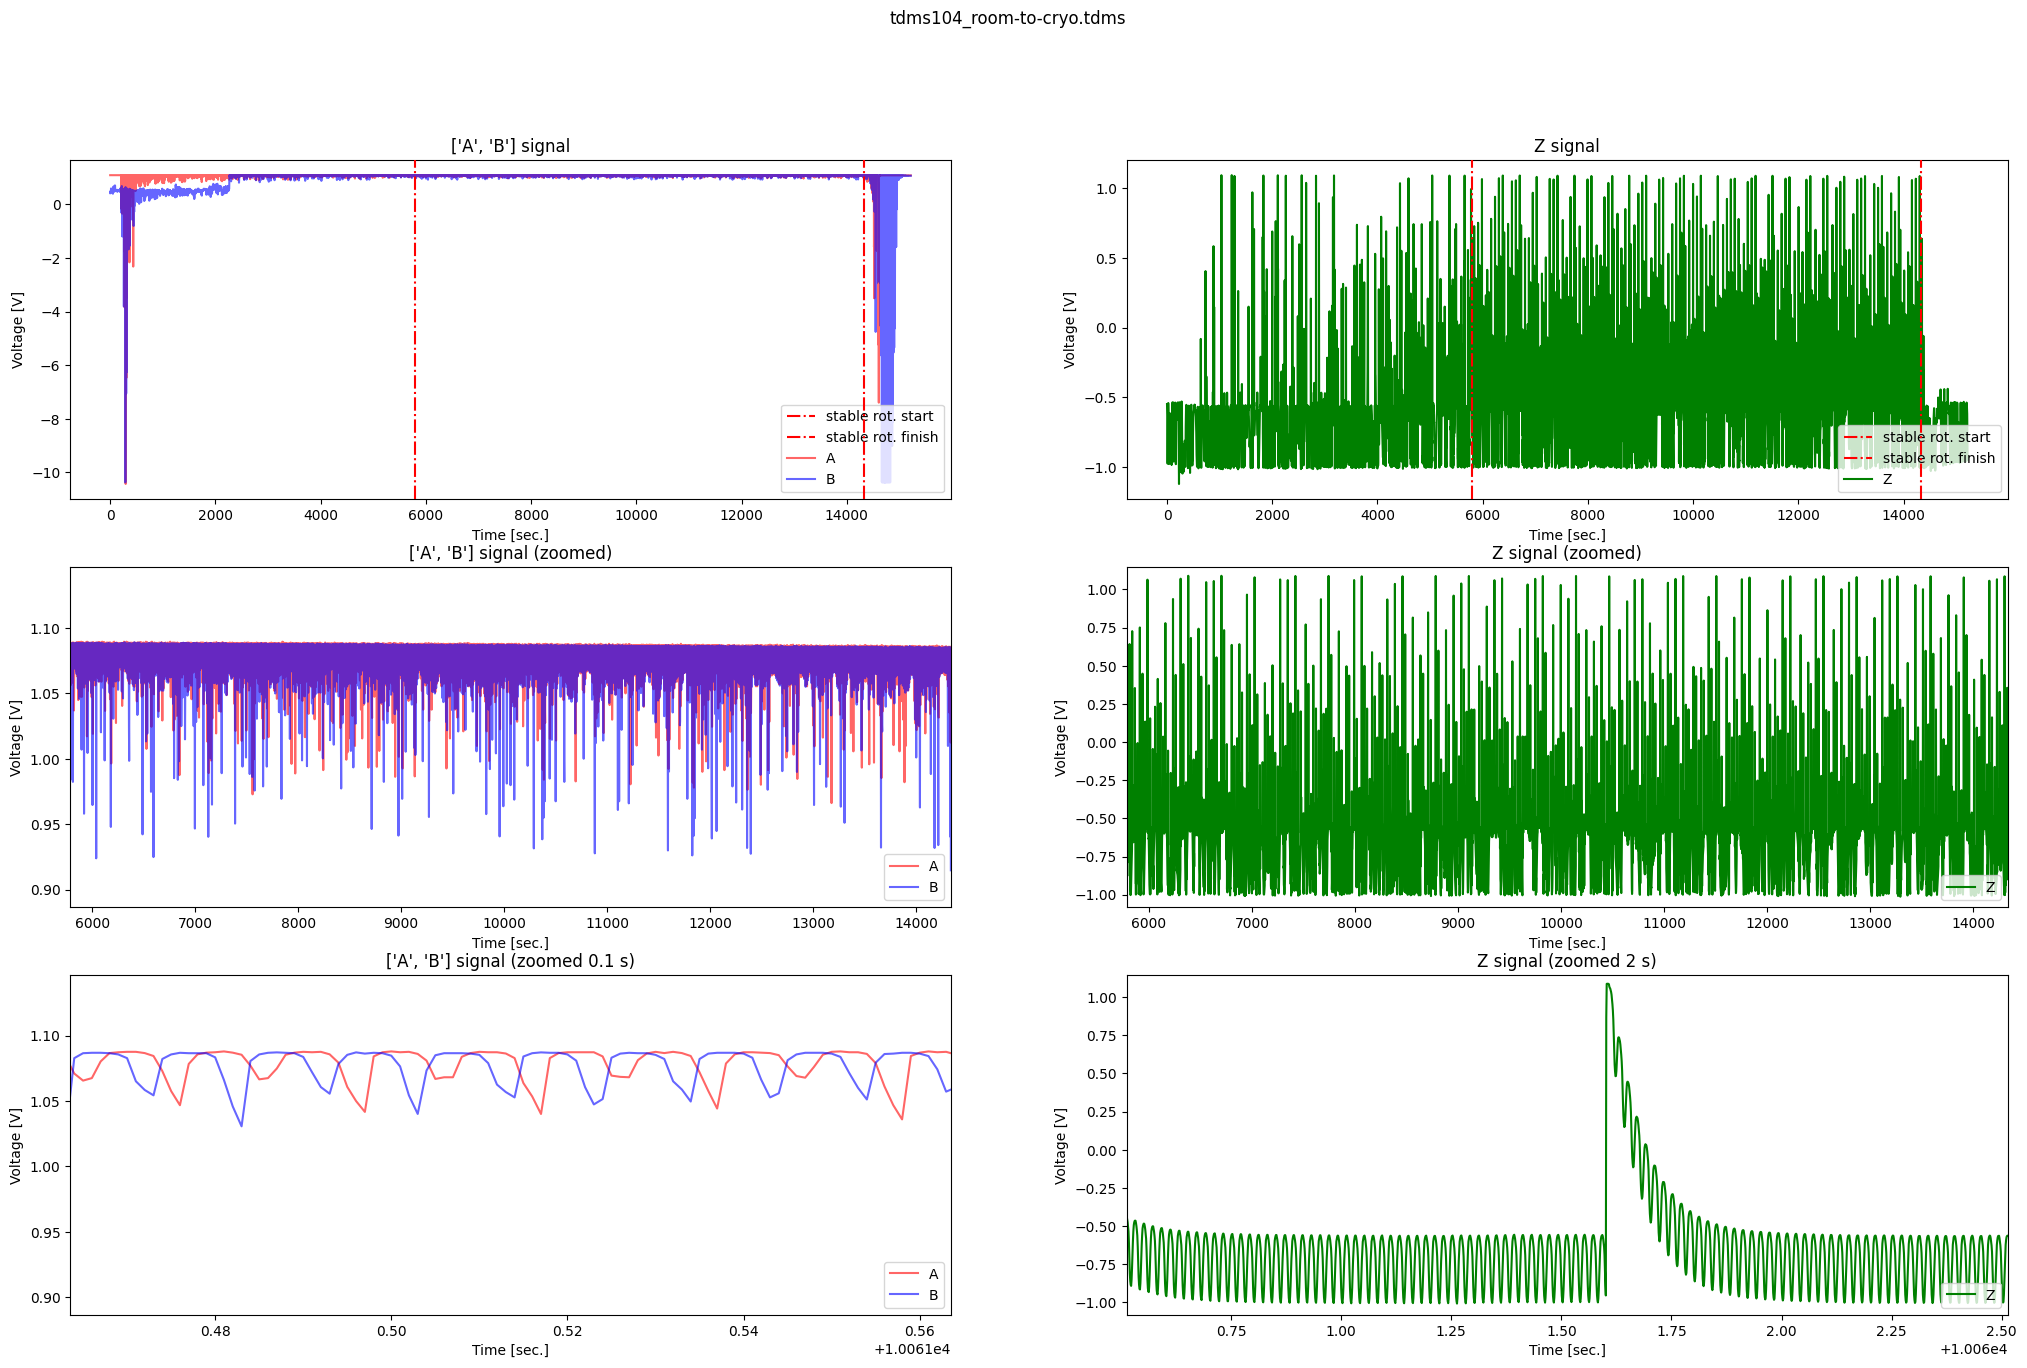

In [7]:
limA, limB, limZ = lib_bbmdev.stability_zone_zoom([df_signal['A'],df_signal['B'],df_signal['Z']], df_signal['time'], 
                                                  stable_str, stable_fin, margin = 0.05, print_=False)


sr = 2000
sec_windowAB, sec_windowZ = 0.1, 2
y_data = df_signal['A'][::sr], df_signal['B'][::sr], df_signal['Z'][::sr]

y_data_zoom = df_signal['A'][::], df_signal['B'][::], df_signal['Z'][::]

x_data = df_signal['time'][::sr]
x_data_zoom = df_signal['time'][::]
fig, axs = plt.subplots(3,2, figsize=(25,15))
plot_data = list(y_data)
plot_data_zoom = list(y_data_zoom)
plot_labels = ["A", "B", "Z"]
plot_col = ["r", "b", "g"]

#first row
# Call the function with common time_data, multiple data arrays, and specified colors
axs[0,0].axvline(x = stable_str,c = 'r',ls='-.',label = 'stable rot. start', zorder=10) # vertical line at the start
axs[0,0].axvline(x = stable_fin,c = 'r',ls='-.',label = 'stable rot. finish', zorder=10) # vertical line at the finish
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[0,0],
    x_data,
    plot_data[0:2],
    labels=plot_labels[0:2],
    plot_col=plot_col[0:2],
    alpha = 0.6
)
# Customize the plot
lib_bbmdev.layout_coil_current_voltage(axs[0,0], "Time [sec.]", "Voltage [V]")
axs[0,0].autoscale(enable=True, axis="x", tight=False)
axs[0,0].autoscale(enable=True, axis="y", tight=False)
axs[0,0].set_title(f'{plot_labels[0:2]} signal')
axs[0,0].legend(loc="lower right")

axs[0,1].axvline(x = stable_str,c = 'r',ls='-.',label = 'stable rot. start', zorder=10) # vertical line at the start
axs[0,1].axvline(x = stable_fin,c = 'r',ls='-.',label = 'stable rot. finish', zorder=10) # vertical line at the finish
lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[0,1],
    x_data,
    [plot_data[2]],
    labels=plot_labels[2],
    plot_col=plot_col[2],
)
lib_bbmdev.layout_coil_current_voltage(axs[0,1], "Time [sec.]", "Voltage [V]")
axs[0,1].autoscale(enable=True, axis="x", tight=False)
axs[0,1].autoscale(enable=True, axis="y", tight=False)
axs[0,1].set_title(f'{plot_labels[2]} signal')
axs[0,1].legend(loc="lower right")


#second row 

lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[1,0],
    x_data,
    plot_data[0:2],
    labels=plot_labels[0:2],
    plot_col=plot_col[0:2],
    alpha = 0.6
)
# Customize the plot
lib_bbmdev.layout_coil_current_voltage(axs[1,0], "Time [sec.]", "Voltage [V]")
axs[1,0].autoscale(enable=True, axis="x", tight=False)
axs[1,0].autoscale(enable=True, axis="y", tight=False)
axs[1,0].set_ylim(limA)
axs[1,0].set_title(f'{plot_labels[0:2]} signal (zoomed)')
axs[1,0].set_xlim(stable_str, stable_fin)
axs[1,0].legend(loc="lower right")

lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[1,1],
    x_data,
    [plot_data[2]],
    labels=plot_labels[2],
    plot_col=plot_col[2],
)
lib_bbmdev.layout_coil_current_voltage(axs[1,1], "Time [sec.]", "Voltage [V]")
axs[1,1].autoscale(enable=True, axis="x", tight=False)
axs[1,1].autoscale(enable=True, axis="y", tight=False)
axs[1,1].set_ylim(limZ)
axs[1,1].set_title(f'{plot_labels[2]} signal (zoomed)')
axs[1,1].set_xlim(stable_str, stable_fin)
axs[1,1].legend(loc="lower right")


#third row

lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[2,0],
    x_data_zoom,
    plot_data_zoom[0:2],
    labels=plot_labels[0:2],
    plot_col=plot_col[0:2],
    alpha= 0.6
)
# Customize the plot
lib_bbmdev.layout_coil_current_voltage(axs[2,0], "Time [sec.]", "Voltage [V]")
axs[2,0].autoscale(enable=True, axis="x", tight=False)
axs[2,0].autoscale(enable=True, axis="y", tight=False)
axs[2,0].set_ylim(limA)
axs[2,0].set_title(f'{plot_labels[0:2]} signal (zoomed {sec_windowAB} s)')
axs[2,0].set_xlim((stable_fin+stable_str)/2 - sec_windowAB/2, (stable_fin+stable_str)/2 + sec_windowAB/2)
axs[2,0].legend(loc="lower right")


lib_bbmdev.plot_multiple_arrays_with_time_and_color(
    axs[2,1],
    x_data_zoom,
    [plot_data_zoom[2]],
    labels=plot_labels[2],
    plot_col=plot_col[2],
)
lib_bbmdev.layout_coil_current_voltage(axs[2,1], "Time [sec.]", "Voltage [V]")
axs[2,1].autoscale(enable=True, axis="x", tight=False)
axs[2,1].autoscale(enable=True, axis="y", tight=False)
axs[2,1].set_ylim(limZ)
axs[2,1].set_title(f'{plot_labels[2]} signal (zoomed {sec_windowZ} s)')
axs[2,1].set_xlim((stable_fin+stable_str)/2 - sec_windowZ/2, (stable_fin+stable_str)/2 + sec_windowZ/2)
axs[2,1].legend(loc="lower right")

fig.suptitle(filename)
plt.show()